## Linestrings buffer

Nesse notebook são construídas as linestrings dos ônibus e aplicado um buffer.

In [1]:
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
from utils.load_csv import load_csv
from utils.save_shp import save_shp

In [2]:
df_onibus = load_csv('calculo-distancia-percorrida_2025-10-19_silver_corrigido.csv')

In [3]:
BUFFER = 10

In [4]:
ids = df_onibus['codigo_onibus'].unique()

ids_subset = np.random.choice(ids, size = 15, replace = False)

df_onibus = df_onibus[df_onibus['codigo_onibus'].isin(ids_subset)]

In [5]:
gdf_onibus = gpd.GeoDataFrame(df_onibus, geometry = gpd.points_from_xy(df_onibus.x, df_onibus.y), crs = 'EPSG:4326')

gdf_onibus = gdf_onibus.to_crs('EPSG:31983')

In [6]:
gdf_onibus = gdf_onibus.sort_values(['codigo_onibus', 'hora_gps']).reset_index(drop = True)

counts = gdf_onibus.codigo_onibus.value_counts()

remover = counts[counts < 2].index

gdf_onibus = gdf_onibus[~gdf_onibus.codigo_onibus.isin(remover)]

In [7]:
linhas = []

for codigo, grupo in gdf_onibus.groupby('codigo_onibus'):

    pts = grupo.geometry.tolist()
    horas = grupo.hora_gps.tolist()

    for i in range(len(pts) - 1):
        if pts[i] != pts[i+1]:
            linhas.append({
                'codigo_onibus': codigo,
                'codigo_linha': grupo.codigo_linha.iloc[0],
                'ponto_inicio': pts[i],
                'ponto_fim': pts[i+1],
                'hora_inicio': horas[i],
                'hora_fim': horas[i+1],
                'geometry': LineString([pts[i], pts[i+1]])
            })

gdf_trajetos = gpd.GeoDataFrame(linhas, geometry = 'geometry', crs = 'EPSG:31983')

In [8]:
gdf_trajetos['buffer'] = gdf_trajetos.geometry.buffer(BUFFER)

<Axes: >

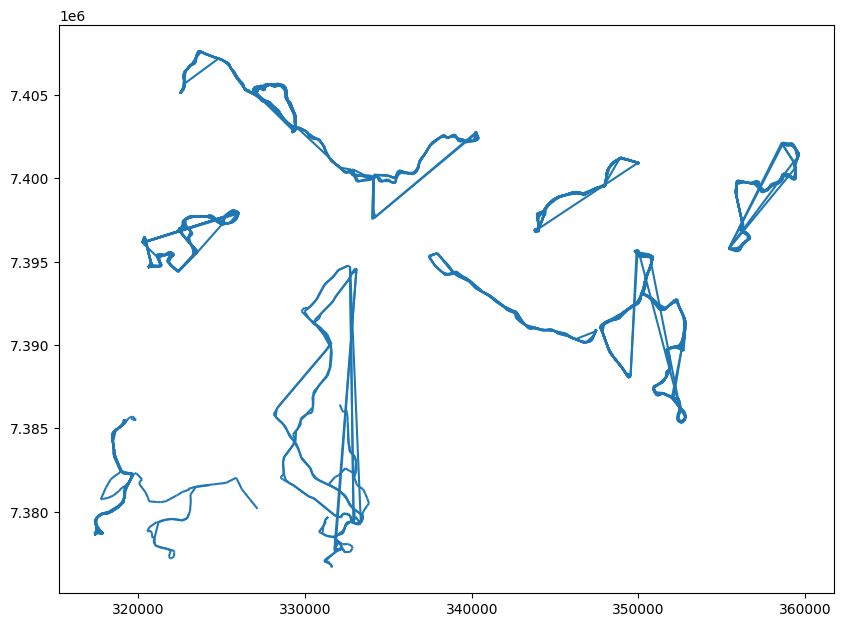

In [9]:
gdf_trajetos.plot(figsize = (10, 10))

In [10]:
gdf_trajetos = gdf_trajetos.set_geometry('buffer')

gdf_trajetos = gdf_trajetos.drop(columns = ['geometry'])

In [11]:
gdf_trajetos = gdf_trajetos.rename(columns = {'codigo_onibus': 'cd_onibus', 
                                              'codigo_linha': 'cd_linha', 
                                              'ponto_inicio': 'pt_inicio', 
                                              'ponto_fim': 'pt_fim', 
                                              'hora_inicio': 'hr_inicio', 
                                              'hora_fim': 'hr_fim'})

In [12]:
save_shp(gdf_trajetos, 'gdf_trajetos.shp')

Shapefile salvo em data\gdf_trajetos.shp
